# Exercise 1: OOP & Pandas Practice

Combine the baby names by state data set into a single file using shell commands.
Write Python code to do the following:
1. Create a class called BabyNames: The class should offer the following interfaces.
2. Make sure to document your class and follow the Python standards.
3. Tell another story from this baby names data set. Support your story with plots.

### Before Creating Class:
I used a shell command below to concatenate all baby names from text files.

`cat *.TXT > combined_baby_names.txt`

Next, we import main python packages and import the consolidated text file.

## Problem 1 Part (a) - Part (g) + Problem 2
Create a class called BabyNames

In [134]:
# Import library packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class BabyNames:
    '''Create BabyNames class to look through baby names data'''

    # Initialize the text file import [Part a]
    def __init__(self, file):
        self.df = pd.read_csv(file, header=None, names=['State','Gender','Year','Name','Count'])
    
    # Create Count function (if state or year are none, then all count of babies will be returned) [Part b]
    def Count(self, state='',year=''):
        # Create a temporary df
        copied_df = self.df.copy()
        # Filter state if exists.
        if state:
            copied_df = copied_df[copied_df['State']==state]
        # Filter year if exists
        if year:
            copied_df = copied_df[copied_df['Year']==year]
        # Return the outptut.
        return f"Total number of baby names: {copied_df['Count'].sum()}"
    
    # Top 10 Baby Names [Part c]
    def top_10_baby_names(self, state='',year=''):
        # Create a temporary df        
        copied_df = self.df.copy()
        # Filter state if exists.
        if state:
            copied_df = copied_df[copied_df['State']==state]
        # Filter year if exists
        if year:
            copied_df = copied_df[copied_df['Year']==year]
        
        # Find the top 10 baby names by male and rank them
        top_10_male = (copied_df[copied_df['Gender']=='M']
                      .groupby('Name')['Count']
                      .sum()
                      .reset_index()
                      .sort_values(by='Count',ascending=False)
                      .head(10))
        
        rank_list = [i for i in range(1,11)]
        
        top_10_male['rank'] = rank_list
        top_10_male = top_10_male[['rank','Name']]
        
        # Find the top 10 baby names by female and rank them
        top_10_female = (copied_df[copied_df['Gender']=='F']
                      .groupby('Name')['Count']
                      .sum()
                      .reset_index()
                      .sort_values(by='Count',ascending=False)
                      .head(10))
        
        top_10_female['rank'] = rank_list
        top_10_female = top_10_female[['rank','Name']]
        
        # Merge Male and Female data together
        df_final = pd.merge(top_10_male,top_10_female,on='rank')
        df_final.columns = ['Rank','Male','Female']
        
        # Return the output
        return df_final.sort_values('Rank')

    # Function that observes the change in popularity of baby names (Regardless of Gender). [Part d]
    def change_of_popularity(self, fromYear=2014, toYear=2015, top=10):
        # Find subsets of fromYear and toYear baby names.
        from_data = self.df[self.df['Year']==fromYear][['Year','Name','Count']].groupby(['Year','Name'])['Count'].sum().reset_index()
        to_data = self.df[self.df['Year']==toYear][['Year','Name','Count']].groupby(['Year','Name'])['Count'].sum().reset_index()
        
        # Merge the data to compare popularity changes
        merged_data = from_data.merge(to_data, on=['Name'], suffixes=('_from', '_to'), how='outer').fillna(0)
        
        # Calculate the change in popularity
        merged_data['PopularityChange'] = merged_data['Count_to'] - merged_data['Count_from']
        
        # Separate names that increased and decreased in popularity
        increased_popularity = merged_data[merged_data['PopularityChange'] > 0]
        decreased_popularity = merged_data[merged_data['PopularityChange'] < 0]
        no_change_popularity = merged_data[merged_data['PopularityChange'] == 0]
        
        # Sort by popularity change
        increased = increased_popularity[['Year_from','Year_to','Name','PopularityChange']].sort_values(by='PopularityChange', ascending=False).head(top)
        decreased = decreased_popularity[['Year_from','Year_to','Name','PopularityChange']].sort_values(by='PopularityChange', ascending=True).head(top)
        
        # Sort the data by Total Occurences Descending order (For no change. Sorting by Pop Change will not work)
        no_change = no_change_popularity.sort_values(by=['Count_to','Name'], ascending=[False,True]).head(top)
        no_change = no_change[['Year_from','Year_to','Name','PopularityChange']]
        
        return increased, decreased, no_change
    
    # Top 5 frequently given baby names in a given year [Part e]
    def top_5_names_year(self, year=2015,sex=''):
        # Copy the data
        copied_df = self.df.copy()
        
        # Apply an initial filter check
        copied_df = copied_df[copied_df['Year'] == year]
        gender = ''
        
        if sex=='M':
            copied_df = copied_df[copied_df['Gender']=='M']
            # Gender for title
            gender = 'Male'
        elif sex=='F':
            copied_df = copied_df[cpoied_df['Gender']=='F']
            gender = 'Female'
        else:
            gender = 'Both Gender'

        # Find Top Five Babies
        ranked_data = (copied_df
                       .groupby(['State','Name'])['Count']
                       .sum()
                       .reset_index()
                       .sort_values(by=['Count','Name'],ascending=[False,True])
                      )

        # Group by 'State' and sort the occurrences in descending order
        grouped = ranked_data.groupby('State').apply(lambda x: x.nlargest(5, 'Count'))
        
        # Reset index to make it flat
        grouped.reset_index(drop=True, inplace=True)
        
        # Re-rank to avoid duplicate rank entries (Not doing it will create an error when pivoting)
        grouped['Rank'] = grouped.groupby('State')['Count'].rank(method='first',ascending=False).astype(int)
        
        # Initialize DataFrames and all existing States.
        final1 = pd.DataFrame()
        final2 = pd.DataFrame()
        state1 = [i for i in grouped.State.unique()]

        # Pivot the table to the desired horizontal format
        for i in state1:
            df = grouped[grouped['State']==i].pivot(index='State', columns='Rank', values=['Name', 'Count'])

            # Flatten the MultiIndex columns
            df.columns = [f'{col[0]} {int(col[1])}' for col in df.columns]

            # Reset the index
            df.reset_index(inplace=True)

            # Rename columns
            df.columns.name = None
            
            # Initialize empty dataframes and unique States dataframe.
            adj_df = pd.DataFrame()
            state = pd.DataFrame(df['State'].unique())
            state = state.rename({0:'State'},axis='columns')

            # Undergo for loop to to output all five individual ranks per Name and Count
            for j in range(5):
                adj_df = pd.concat([adj_df,df.iloc[:,1+j],df.iloc[:,6+j]],axis=1)
            
            # Combine
            final1 = pd.concat([state,adj_df],axis=1)
            final2 = pd.concat([final2,final1])
        final2.columns = ['State','Rank 1','Num','Rank 2','Num',
                      'Rank 3','Num','Rank 4','Num','Rank 5','Num']
        
        # Add the title
        final2 = final2.style.set_caption(f"Top Five {gender} Names for Births in {year}")            
        
        # Return the output
        return final2
        
    
    # Name Popularity Plot [Part f]
    def name_popularity_plot(self, name='Jim',yearRange=(2000,2015),state='IL',sex='M'):
        if isinstance(name,list):
            print('Please input only one name.')
        elif isinstance(name,str):
            # Copy the data
            copied_df = self.df.copy()

            # Filter the data based on the input provided
            copied_df = copied_df[(copied_df['Name']==name) & (copied_df['Year']>=yearRange[0]) & (copied_df['Year']<=yearRange[1]) & (copied_df['State']==state) & (copied_df['Gender']==sex)]

            # Prepare the plot
            x = copied_df['Year']
            y = copied_df['Count']

            plt.plot(x,y)
            plt.title(f'Popularity change of {name} from {yearRange[0]} to {yearRange[1]}')
            plt.xlabel('Year')
            plt.ylabel('Name Popularity')
            plt.show()
            
            return plt.show()
            
    # Find Baby Names that flipped in popularity by Gender [Part g]
    def name_flip(self, n=10):
        # Copy the data
        copied_df = self.df.copy()
        
        # Narrow down names that have both Males and Females
        male = copied_df[(copied_df['Gender']=='M')].groupby('Name')['Count'].sum().reset_index()
        female = copied_df[(copied_df['Gender']=='F')].groupby('Name')['Count'].sum().reset_index()        
        
        # Find matching names
        matched = pd.merge(male,female,on='Name',suffixes=('_male','_female'),how='inner')
        filtered_name = list(matched['Name'].unique())
        
        # Filter to categories that have names in both genders
        filtered_data = copied_df[copied_df['Name'].isin(filtered_name)]
        
        # Initialize
        flipped_name = []
        
        # Loop through to narrow down names that flipped
        for i in filtered_name:
            i_data = filtered_data[filtered_data['Name']==i].groupby(['Year','Gender'])['Count'].sum().reset_index()
            
            # Male first
            if i_data[i_data['Gender']=='M']['Year'].iloc[0] < i_data[i_data['Gender']=='F']['Year'].iloc[0]:
                if i_data[i_data['Gender']=='M']['Count'].sum() < i_data[i_data['Gender']=='F']['Count'].sum():
                    flipped_name.append(i)
            # Female first
            elif i_data[i_data['Gender']=='M']['Year'].iloc[0] > i_data[i_data['Gender']=='F']['Year'].iloc[0]:
                if i_data[i_data['Gender']=='M']['Count'].sum() > i_data[i_data['Gender']=='F']['Count'].sum():
                    flipped_name.append(i)
        
        # Top 10 filtered names that have the most counts
        top_n = filtered_data[filtered_data['Name'].isin(flipped_name)].groupby('Name')['Count'].sum().reset_index().sort_values(by='Count',ascending=False).head(n)
        top_n_names = list(top_n['Name'].unique())
        
        # Filter to 10 names
        final_data = filtered_data[filtered_data['Name'].isin(top_n_names)]
        final_data = final_data[['Year','Name','Count','Gender']]        
        
        # Plot the subplots by Names
        plt.figure(figsize=(15, 12))

        # set number of columns
        ncols = 3
        # calculate number of rows
        nrows = n // ncols + (n % ncols > 0)

        # loop through the length of top n names and keep track of index
        for p, name in enumerate(top_n_names):
            # Find male and female data
            name_data = final_data[final_data['Name']==name][['Year','Gender','Count']]
            
            male_final = name_data[name_data['Gender']=='M'].groupby('Year')['Count'].sum().reset_index()

            female_final = name_data[name_data['Gender']=='F'].groupby('Year')['Count'].sum().reset_index()

            grouped = pd.merge(male_final,female_final, on='Year', how='outer', suffixes=['_male','_female']).fillna(0)
            grouped['perc_male'] = grouped['Count_male'] / (grouped['Count_male'] + grouped['Count_female'])
            grouped['perc_female'] = grouped['Count_female'] / (grouped['Count_male'] + grouped['Count_female'])
            grouped = grouped.sort_values('Year')
            
            # add a new subplot iteratively using nrows and cols
            plt.subplot(nrows, ncols, p + 1)

            # filter df and plot ticker on the new subplot axis
            plt.plot(grouped['Year'], grouped['perc_male'], color = 'darkblue', label = '% male', alpha = 0.5)
            plt.plot(grouped['Year'], grouped['perc_female'], color = 'darkred', label = '% female', alpha = 0.5)
            plt.legend()
            plt.title(f'Trend of {name} Over Time by Gender')
        
        plt.tight_layout()
        
        # Output Plot
        return plt.show()

In [135]:
# Test Run
BabyTest = BabyNames('./babynamesbystate/combined_baby_name.txt')

In [3]:
# Count the number of Baby Names in California
BabyTest.Count('CA',2000)

'Total number of baby names: 471610'

In [4]:
# Find the Top 10 Babies for all States
BabyTest.top_10_baby_names()

,Rank,Male,Female
0,1,James,Mary
1,2,John,Patricia
2,3,Robert,Elizabeth
3,4,Michael,Jennifer
4,5,William,Linda
5,6,David,Barbara
6,7,Richard,Margaret
7,8,Joseph,Susan
8,9,Charles,Dorothy
9,10,Thomas,Jessica


In [5]:
# Find the change in popularity for baby names
BabyTest.change_of_popularity(fromYear=2014,toYear=2015,top=10)

(      Year_from  Year_to       Name  PopularityChange
 7369     2014.0   2015.0     Oliver            2217.0
 467      2014.0   2015.0      Alexa            1793.0
 6812     2014.0   2015.0        Mia            1397.0
 3854     2014.0   2015.0      Hazel            1396.0
 3664     2014.0   2015.0    Grayson            1357.0
 6640     2014.0   2015.0     Matteo            1356.0
 2087     2014.0   2015.0  Charlotte            1287.0
 6623     2014.0   2015.0      Mateo            1277.0
 6052     2014.0   2015.0    Lincoln            1205.0
 8236     2014.0   2015.0   Scarlett            1127.0,
       Year_from  Year_to       Name  PopularityChange
 4522     2014.0   2015.0     Jayden           -1562.0
 4073     2014.0   2015.0   Isabella           -1472.0
 4437     2014.0   2015.0       Jase           -1453.0
 8511     2014.0   2015.0     Sophia           -1201.0
 4863     2014.0   2015.0     Joshua           -1102.0
 888      2014.0   2015.0  Annabelle           -1084.0
 807     

In [6]:
# Return top 5 names in the year 2013 for Male
BabyTest.top_5_names_year(2013,'M')

,State,Rank 1,Num,Rank 2,Num,Rank 3,Num,Rank 4,Num,Rank 5,Num
0,AK,Liam,64,William,49,Mason,47,Noah,46,Wyatt,46
0,AL,William,438,Mason,293,James,288,John,281,Elijah,247
0,AR,William,196,Mason,187,Noah,161,James,147,Elijah,138
0,AZ,Jacob,389,Noah,389,Liam,388,Alexander,370,Daniel,362
0,CA,Jacob,2890,Ethan,2667,Daniel,2603,Jayden,2581,Matthew,2565
0,CO,Liam,350,Noah,309,Jackson,269,Alexander,262,William,258
0,CT,William,208,Mason,198,Jacob,193,Noah,192,Michael,187
0,DC,William,87,Alexander,77,John,70,Henry,69,Samuel,61
0,DE,Michael,62,Mason,60,Liam,58,Aiden,51,William,50
0,FL,Jayden,1126,Jacob,1099,Liam,1074,Noah,1050,Michael,987


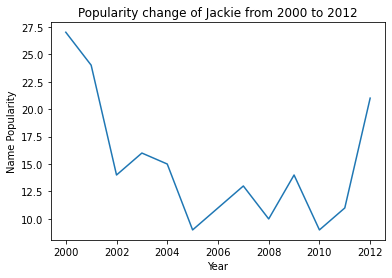

In [7]:
# Find my name popularity in the year 2000 ~ 2012 in California.
BabyTest.name_popularity_plot('Jackie',(2000,2012),'CA','M')

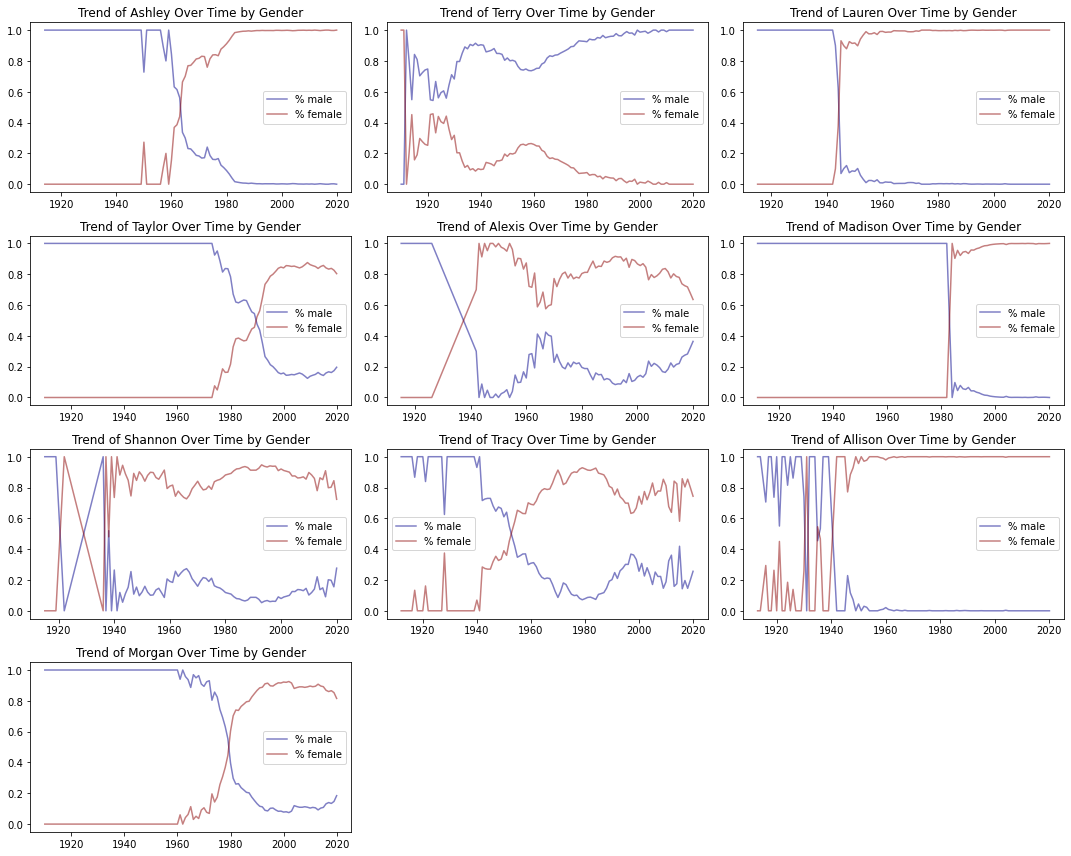

In [136]:
# Find top 10 names that flipped in popularity by gender
BabyTest.name_flip(10)